In [430]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn import random_projection as RP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import mean_squared_error as MSE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

In [317]:
df = pd.read_csv("data/cancer/breast-cancer.csv", index_col="id")

In [318]:
df = df.drop(columns='Unnamed: 32')

In [319]:
df.shape

(569, 31)

# Exploratory Data Analysis

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

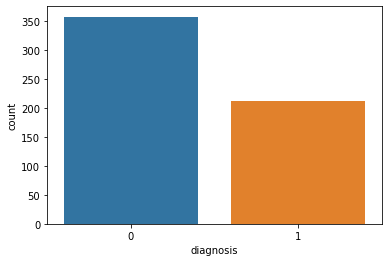

In [320]:
diagnosis_map = {'B':0, 'M':1}
df['diagnosis'] = df['diagnosis'].map(diagnosis_map)

sns.countplot(x=df['diagnosis'])

# Split data

In [323]:
x = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [324]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [325]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [326]:
print(f"train set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

train set size: (455, 30)
test set size: (114, 30)


# Scale

In [327]:
scaler = StandardScaler()

In [328]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)

In [329]:
print(np.min(x_train_sc))
print(np.max(x_train_sc))

-3.176344188780568
11.731855390439586


In [330]:
mm_scaler = MinMaxScaler()

In [331]:
x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.fit_transform(x_test)

In [332]:
print(np.min(x_train_mm))
print(np.max(x_train_mm))

0.0
1.0


# 1) Run Clustering

## 1.1) K-Means

In [334]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(x_train_sc)
    sum_of_squared_distances.append(km.inertia_)

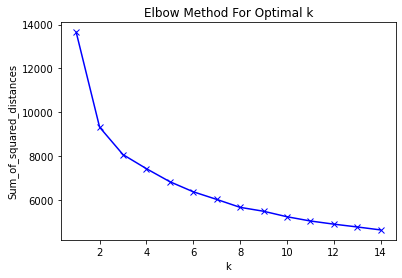

In [335]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [336]:
# Silhouette Score: This is a better measure to decide the number of clusters to be formulated from the data. 
# It is calculated for each instance and the formula goes like this:
# Silhouette Coefficient = (x-y)/ max(x,y)

# consider two measures:
#   The mean distance between a sample and all other points in the same cluster.
#   The mean distance between a sample and all other points in the next nearest cluster.
# i.e. it checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

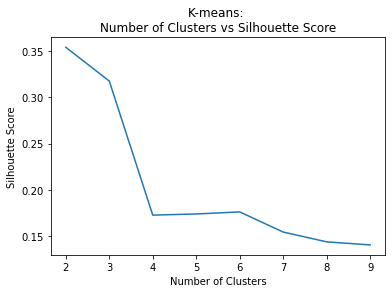

In [568]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_train_sc)
    labels = km.predict(x_train_sc)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    data.append([n, sil])

kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"])
plt.show()


In [567]:
# n_clusters=np.arange(2, 10)
# data=[]

# for n in n_clusters:
#     km = KMeans(n, random_state=0)
#     km = km.fit(x_train_sc)
#     labels = km.predict(x_train_sc)
#     sil = silhouette_score(x_train_sc, labels, metric='manhattan')
    
#     data.append([n, sil])

# kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

# plt.title("K-means: \nNumber of Clusters vs Silhouette Score")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Score") 
# plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"])
# plt.show()


## 1.2) EM

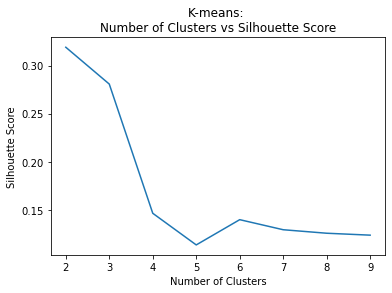

In [338]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_train_sc)
    labels = gmm.predict(x_train_sc)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    data.append([n, sil])

em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(em_df["Clusters"], em_df["Silhouette Score"])
plt.show()

In [339]:
### BIC
# Bayesian information criterion (BIC)
# how much is good the GMM in terms of predicting the data we actually have. 
# The lower is the BIC, the better is the model to actually predict the data we have

# 2) Dimensionality reduction

## 2.1) PCA

In [341]:
retain_variance = 0.90

pca = PCA(retain_variance)
principalComponents = pca.fit(x_train_sc)

comp_num = pca.n_components_

print(f"{comp_num} components picked to retain {retain_variance} variance")

7 components picked to retain 0.9 variance


In [342]:
pca = PCA(n_components=comp_num)
principalComponents = pca.fit_transform(x_train_sc)

In [343]:
columns = []
for i in range(comp_num):
    columns.append(f"principal component {i+1}")
    
print(columns)

['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7']


In [344]:
principalDf = pd.DataFrame(data = principalComponents, columns = columns)

In [345]:
principalDf['diagnosis'] = y_train.values

In [346]:
principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,diagnosis
0,-3.039161,1.106670,0.408520,0.651555,-1.441651,-0.144347,-0.239526,0
1,-2.282314,0.400452,0.263275,1.701245,-0.466131,0.602709,-0.252815,0
2,-1.084095,-1.995444,-1.193536,-1.491333,0.565976,0.192945,-0.540865,0
3,-2.561100,0.179338,1.085279,-0.621311,-0.474188,-0.176897,-0.257803,0
4,-2.848305,-1.017616,-0.847290,1.762525,-0.021795,0.302202,0.756510,0


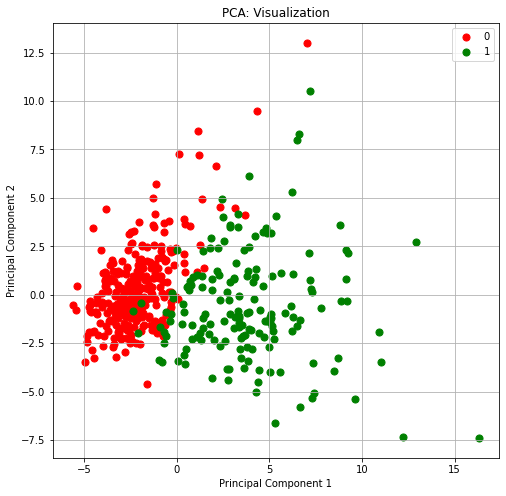

In [347]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA: Visualization')

diagnosis = [0, 1]
colors = ['r', 'g']

for target, color in zip(diagnosis, colors):
    indicesToKeep = principalDf['diagnosis'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

    ax.legend(diagnosis)
ax.grid()

In [348]:
# The explained variance tells you how much information (variance) can be 
# attributed to each of the principal components

In [349]:
print("Explained variation per principal component:\n")
print(pca.explained_variance_ratio_)

Explained variation per principal component:

[0.43430767 0.19740115 0.09351771 0.06677661 0.05642452 0.04071619
 0.02149254]


In [350]:
np.sum(pca.explained_variance_ratio_)

0.9106363829667495

In [351]:
def run_pca(x_train):
    """
    Run PCA and plot variance retained for each number of components
    """
    
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1): 
        pca = PCA(n_components=num)
        principalComponents = pca.fit_transform(x_train)
        
        variance_retained = np.sum(pca.explained_variance_ratio_)
        
        data.append([num, variance_retained])
        
    df = pd.DataFrame(data, columns=["Features", "Variance Retained"])
    
    plt.title("PCA: \nNumber of Features vs Variance Retained")
    plt.xlabel("Number of Features")
    plt.ylabel("Variance Retained") 
    plt.plot(df["Features"], df["Variance Retained"])
    plt.show()

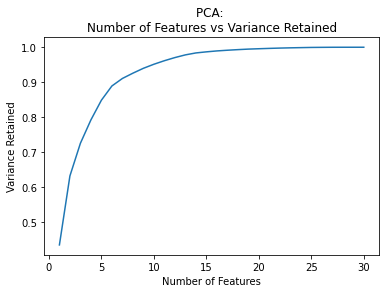

In [352]:
run_pca(x_train_sc)

In [353]:
# 7 features to retain 90% of the variance

## 2.2) ICA

In [465]:
def run_ica(x_train):
    """
    Run ICA from n_components 1 to N and get average  kurtosis
    """
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1):    
        transformer = ICA(n_components=num, random_state=1)
        x_transformed = transformer.fit_transform(x_train)

        x_transformed = pd.DataFrame(x_transformed)
        kurtosis = x_transformed.kurtosis(axis=0)
        kurtosis_mean = kurtosis.abs().mean()
        
        data.append(kurtosis_mean)
        print(kurtosis_mean)
        

    plt.xlabel("Number of IC")
    plt.ylabel("Kurtosis")
    plt.plot(range(1, n+1), data)
    plt.grid()
    plt.show()

0.9966876299638496
3.3897492250606565
5.406149429145649
5.415230219448011
7.445496500988307
7.4109203337168035
10.568569732472094
10.274706826617273
13.777010319785317
12.528528260895738
20.566771932520833
20.213388380093495
19.8864940526865
19.339770929473048
20.99305490839481
19.75408149198722
23.694582398739893
24.037110250289032
25.15993276184566
24.07186047277841
27.42101977232737
28.13155463628747
31.037531206840768
32.303390635968974
32.22281120380724
32.22389717823272
32.139322835617165
32.33884870837955
32.91571047717762
32.785433512102756


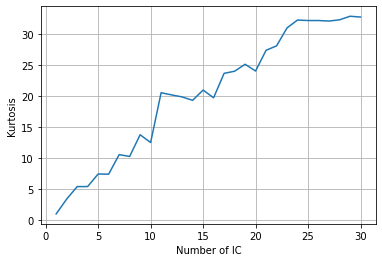

In [466]:
run_ica(x_train_sc)

In [467]:
def run_ica_2(x_train):
    """
    Run ICA for N n_components kurtosis for each component
    """
    n = x_train_sc.shape[1]  
    transformer = ICA(n_components=n, random_state=1)
    x_transformed = transformer.fit_transform(x_train)
    x_transformed = pd.DataFrame(x_transformed)    
    kurtosis = x_transformed.kurtosis(axis=0)
    print(kurtosis)
    kurtosis_abs = kurtosis.abs()
        
    data = []
    for i, k in enumerate(kurtosis_abs):
        data.append([f"IC{i+1}", k])
    
    p = pd.DataFrame(data, columns=["IC", "Kurtosis"])
    
    # get only top 10 IC    
    p.sort_values(by="Kurtosis", ascending=False, inplace=True)
    
    x_labels = p["IC"][:10]
    y_values = p["Kurtosis"][:10]    
    
#     plt.title(title)
    plt.ylabel("Kurtosis") 
    plt.bar(x_labels, y_values)
    plt.show()
    


0       5.319324
1      30.395974
2     249.347397
3       9.110305
4       2.742234
5       6.705590
6      36.371168
7       2.741200
8       1.621688
9       6.822335
10      8.936210
11     17.076922
12      4.582964
13    207.711469
14      8.646260
15     28.729292
16      3.861676
17      5.698056
18      2.849086
19     90.071003
20      3.579560
21      3.752915
22     42.381443
23     13.916546
24     45.997824
25     97.212462
26      5.306371
27     12.047651
28     12.548979
29     17.479105
dtype: float64


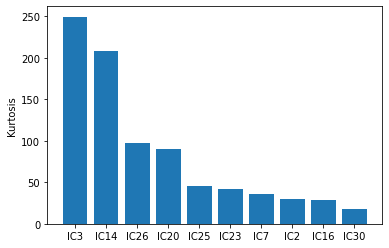

In [468]:
run_ica_2(x_train_sc)

## 2.3 RCA  (Randomized Projection)

In [532]:
def run_rp(x_train):
    """
    random projection
    """

    n = x_train_sc.shape[1]
    
    # Run 1
    data = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=0)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data.append([num, error])
        
        print(f"{num} error={error}")
       
    # Run 2
    data_2 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=10)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_2.append([num, error])
        
#         print(f"{num} error={error}")
        

    # Run 3
    data_3 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=20)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_3.append([num, error])
        
#         print(f"{num} error={error}")
    
    df = pd.DataFrame(data, columns=["Features", "Reconstruction Error (MSE)"])
    df_2 = pd.DataFrame(data_2, columns=["Features", "Reconstruction Error (MSE)"])
    df_3 = pd.DataFrame(data_3, columns=["Features", "Reconstruction Error (MSE)"])
      
    plt.title("Random Projection: \nNumber of Features vs Reconstruction Error")
    plt.xlabel("Number of Features")
    plt.ylabel("Reconstruction Error (MSE)") 
    plt.plot(df["Features"], df["Reconstruction Error (MSE)"], label="random_state=1")
    plt.plot(df_2["Features"], df_2["Reconstruction Error (MSE)"], label="random_state=2")
    plt.plot(df_3["Features"], df_3["Reconstruction Error (MSE)"], label="random_state=3")
    
    plt.legend()
    plt.show()

1 error=0.9591388869980736
2 error=0.9402563262606025
3 error=0.8997627582750789
4 error=0.7804784445097371
5 error=0.7720018025369867
6 error=0.7398317399772064
7 error=0.6837749139819014
8 error=0.6643771233479747
9 error=0.638833114930472
10 error=0.5965833065858527
11 error=0.5713166734123777
12 error=0.5386771986395035
13 error=0.47834198302005343
14 error=0.4286268960595964
15 error=0.40464821208114027
16 error=0.3855461633381738
17 error=0.36928747357999114
18 error=0.32229227103860636
19 error=0.30987486361945327
20 error=0.2602769995951951
21 error=0.24103065783634556
22 error=0.23176286141676572
23 error=0.218649436904855
24 error=0.1490881012782022
25 error=0.12866219075200863
26 error=0.10561464873869184
27 error=0.059350765649550684
28 error=0.02745783743869112
29 error=0.013707656458000919
30 error=1.3705112033626296e-29


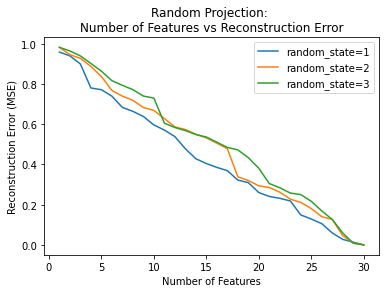

In [533]:
run_rp(x_train_sc)

In [535]:
# highest error is 0.959138 @ 1 component and lowest error ~0
# pick a threashold of 10% error rate
# 0.959138*(0.1) = 0.0959138 MSE
# we see this at ~26 componenets

## 2.4 LDA (Linear Discriminant Analysis)

In [395]:
def run_lda(x_train, y_train):
    """
    Linear Discriminant Analysis
    """

    # n_components cannot be larger than min(n_features, n_classes - 1).
    
    n_features = x_train_sc.shape[1]
    n_classes = len(np.unique(y_train))
    n = np.min([n_features, n_classes - 1])
    
    data = []
    
    for num in range(1, n+1):
        clf = LDA(n_components=num)
        x_transformed = clf.fit_transform(x_train, y_train)


In [396]:
run_lda(x_train_sc, y_train)

# 3) DR -> Clustering

- 3.1) PCA -> K-means
- 3.2) PCA -> EM

- 3.3) ICA -> K-means
- 3.4) ICA -> EM

- 3.5) RP -> K-means
- 3.6) RP -> EM

- 3.7) LDA -> K-means
- 3.8) LDA -> EM

## 3.1) PCA -> K-means

In [376]:
pca = PCA(n_components = 7)
x_transformed = pca.fit_transform(x_train_sc)

x_transformed = pd.DataFrame(x_transformed)

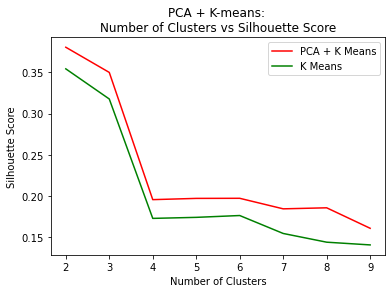

In [377]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("PCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_df["Clusters"], pca_kmeans_df["Silhouette Score"], color='r', label='PCA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.2) PCA -> EM

In [378]:
pca = PCA(n_components = 7)
x_transformed = pca.fit_transform(x_train_sc)

x_transformed = pd.DataFrame(x_transformed)

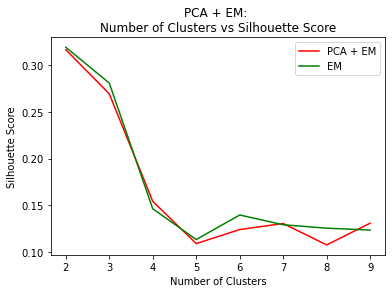

In [379]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("PCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='PCA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

## 3.3) ICA -> K-means

In [469]:
transformer = ICA(n_components=24, random_state=1)
x_transformed = transformer.fit_transform(x_train_sc)

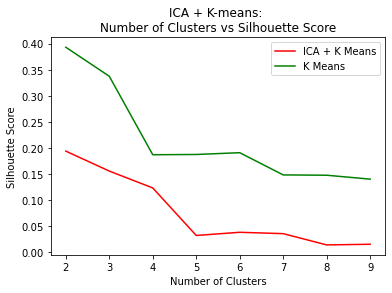

In [470]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("ICA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='ICA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.4) ICA -> EM

In [471]:
transformer = ICA(n_components=24, random_state=1)
x_transformed = transformer.fit_transform(x_train_sc)

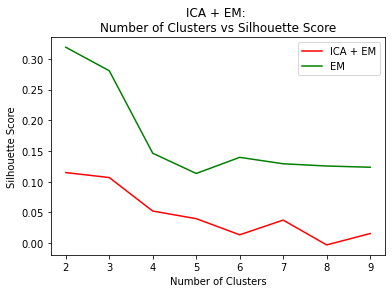

In [472]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("ICA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='ICA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

In [ ]:
`

## 3.5) RP -> K-means

In [540]:
transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

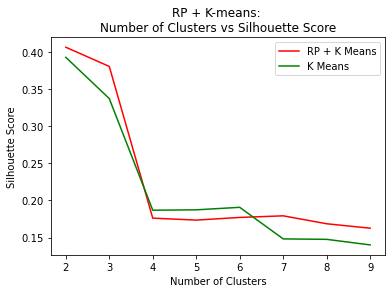

In [541]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("RP + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='RP + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.6) RP -> EM

In [542]:
transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

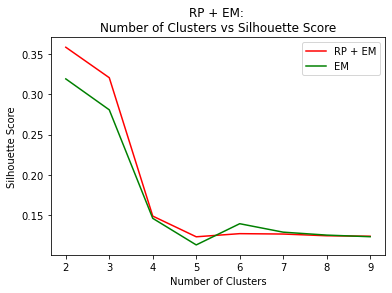

In [543]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("RP + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='RP + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

## 3.7) LDA -> K-means

In [397]:
clf = LDA(n_components=1)
x_transformed = clf.fit_transform(x_train_sc, y_train)

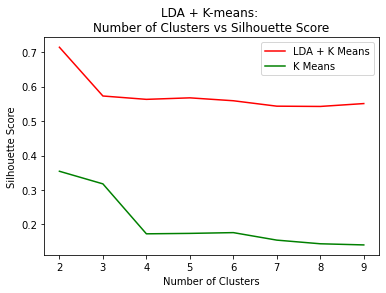

In [398]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("LDA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='LDA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.8) LDA -> EM

In [400]:
clf = LDA(n_components=1)
x_transformed = clf.fit_transform(x_train_sc, y_train)

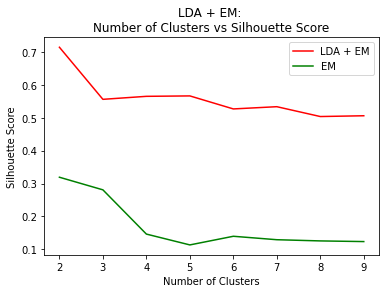

In [401]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("LDA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='LDA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

# 4) DR -> NN

- 4.1) PCA -> NN
- 4.2) ICA -> NN
- 4.3) RP -> NN
- 4.4) LDA -> NN

In [447]:
def nn_per_epoch(X, y, activation, alpha, hidden_layer_size, max_epoches):
    epochs = []
    train_scores = []
    val_scores = []
    
    for epoch in range(10, max_epoches+1, 20):
        mlp_clf = MLPClassifier(
            hidden_layer_sizes=hidden_layer_size,
            activation=activation, 
            alpha=alpha, 
            max_iter=epoch,
            random_state=0
        )
        
        val_score = cross_val_score(
            estimator=mlp_clf,
            X=X,
            y=y,
            scoring="accuracy",
            cv=10
        )
        val_score = val_score.mean()
        
        mlp_clf.fit(X, y)
        train_score = mlp_clf.score(X, y)
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        epochs.append(epoch)

    plt.title("Neural Net Learning Curve\nHidden Layers="+str(hidden_layer_size))
    plt.xlabel("epochs")
    plt.ylabel("Score")

    plt.plot(epochs, train_scores, label="Training score", color="r")
    plt.plot(epochs, val_scores, label="Cross-validation score", color="g")


    plt.legend(loc="best")
    plt.show()

In [428]:
def plot_model_curve(estimator, title, X, y, param_name, param_range, cv=10, n_jobs=None, x_scale_is_log=False):
    """
    https://scikit-learn.org/0.15/auto_examples/plot_validation_curve.html
    """
    
    train_scores, test_scores = validation_curve(
        estimator, 
        X, 
        y, 
        param_name=param_name, 
        param_range=param_range,
        cv=cv, 
        scoring="balanced_accuracy", 
        n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    
    if x_scale_is_log:
        plt.xscale('log')

    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

    plt.legend(loc="best")

    return plt

In [433]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=10,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring="balanced_accuracy",
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Training time of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    print("Train accuracy:", train_scores_mean[-1])
    print("Validation accuracy:", test_scores_mean[-1])
    print("Train Time:", fit_times_mean[-1])
    
    return plt

## 4.1) PCA -> NN

In [499]:
pca = PCA(n_components = 7)
x_train_transformed = pca.fit_transform(x_train_sc)
x_test_transformed = pca.transform(x_test_sc)

x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

In [500]:
x_train_transformed

,0,1,2,3,4,5,6
0,-3.039161,1.106670,0.408520,0.651555,-1.441651,-0.144347,-0.239526
1,-2.282314,0.400452,0.263275,1.701245,-0.466131,0.602709,-0.252815
2,-1.084095,-1.995444,-1.193536,-1.491333,0.565976,0.192945,-0.540865
3,-2.561100,0.179338,1.085279,-0.621311,-0.474188,-0.176897,-0.257803
4,-2.848305,-1.017616,-0.847290,1.762525,-0.021795,0.302202,0.756510
...,...,...,...,...,...,...,...
450,0.081023,-3.420671,0.346485,-0.399640,0.436049,-0.106760,-1.798765
451,6.513019,7.996828,-4.505699,3.254753,1.465748,-0.760592,2.887959
452,-3.170461,0.516009,0.523623,0.044899,-0.778464,-1.087733,1.293050
453,-5.611046,-0.538805,4.127448,2.559791,-0.732230,1.905993,0.891893


In [501]:
# x_train_transformed_mm = mm_scaler.fit_transform(x_train_transformed)
# x_test_transformed_mm = mm_scaler.fit_transform(x_test_transformed)

#### Check with A1 network

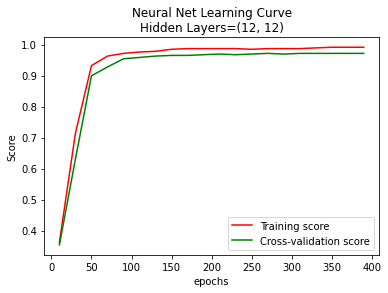

In [502]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune hyper params: Alpha

In [503]:
# param_range = np.logspace(-3, 1, 20)

# nn_clf = MLPClassifier(
#     hidden_layer_sizes=(12, 12),
#     activation='relu',
#     max_iter=300,
#     random_state=0
# )

# plot_model_curve(
#     estimator=nn_clf,
#     title="alpha vs score",
#     X=x_train_transformed,
#     y=y_train,
#     param_name="alpha",
#     param_range=param_range,
#     cv=10,
#     x_scale_is_log=True
# )

Train accuracy: 0.9626155468929131
Validation accuracy: 0.951717799188641
Train Time: 0.2461874008178711


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

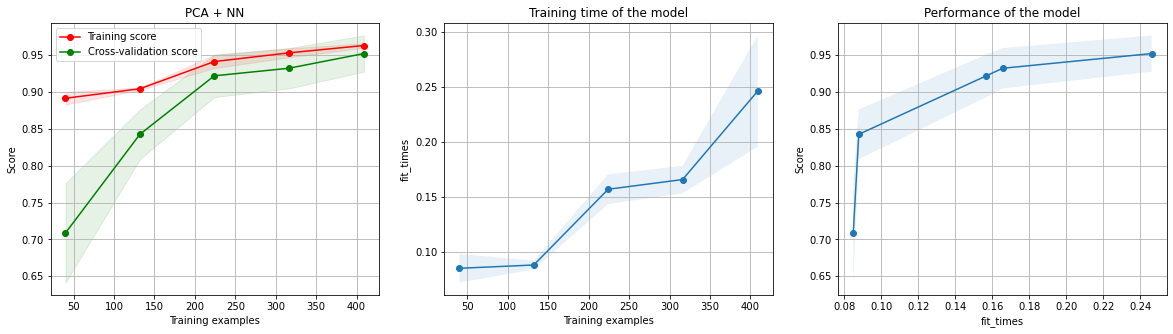

In [510]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=110,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="PCA + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [514]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=110,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0021719932556152344
Test Accuracy: 0.9736842105263158


## 4.2) ICA -> NN

In [515]:
transformer = ICA(n_components=24, random_state=1)
x_train_transformed = transformer.fit_transform(x_train_sc)
x_test_transformed = transformer.transform(x_test_sc)

In [516]:
x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

In [477]:
# x_train_transformed_mm = mm_scaler.fit_transform(x_train_transformed)
# x_test_transformed_mm = mm_scaler.fit_transform(x_test_transformed)

#### check with A1 NN

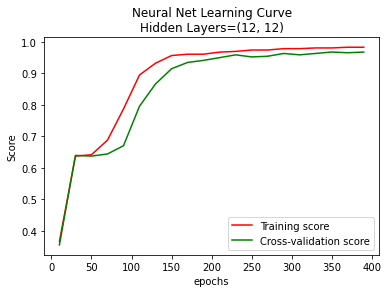

In [517]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.01,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

In [519]:
# nn_per_epoch(
#     X=x_train_transformed, 
#     y=y_train, 
#     activation='relu',
#     alpha=0.01,
#     hidden_layer_size=(12, 12),
#     max_epoches=400
# )

#### Tune Alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

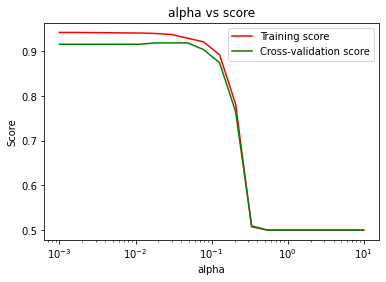

In [520]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=200,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_transformed,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9427149464901141
Validation accuracy: 0.9189338235294118
Train Time: 0.5378647327423096


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

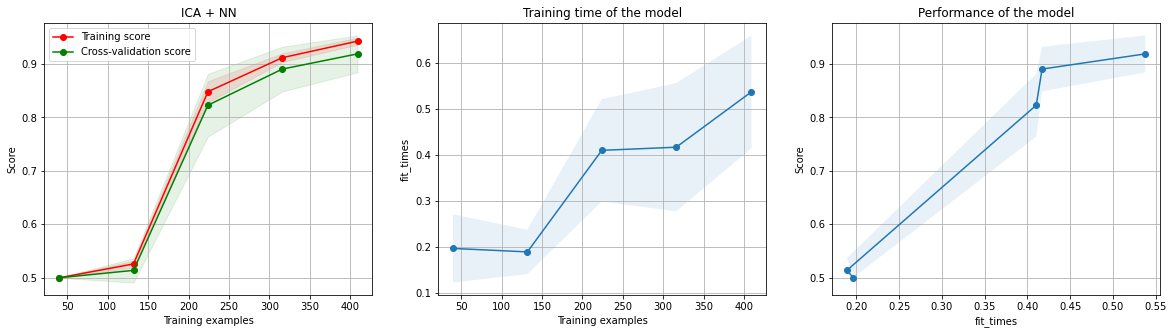

In [522]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.01, 
    max_iter=200,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="ICA + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [523]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.01, 
    max_iter=200,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.006478071212768555
Test Accuracy: 0.9298245614035088


In [496]:
# print(classification_report(y_test, dt_y_preds))

## 4.3) RP -> NN

In [557]:
transformer = RP.GaussianRandomProjection(n_components=26, random_state=0)
x_train_transformed = transformer.fit_transform(x_train_sc)
x_test_transformed = transformer.transform(x_test_sc)

In [558]:
x_train_transformed = pd.DataFrame(x_train_transformed)
x_test_transformed = pd.DataFrame(x_test_transformed)

#### check with A1 NN

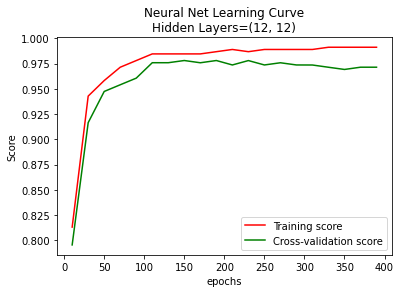

In [560]:
nn_per_epoch(
    X=x_train_transformed, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

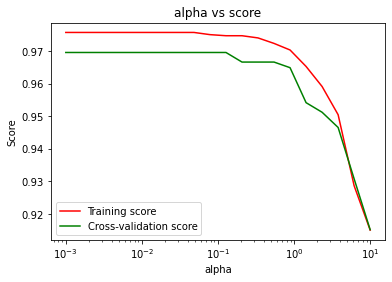

In [561]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=125,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_transformed,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9753209974345127
Validation accuracy: 0.9678055273833671
Train Time: 0.3499213695526123


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

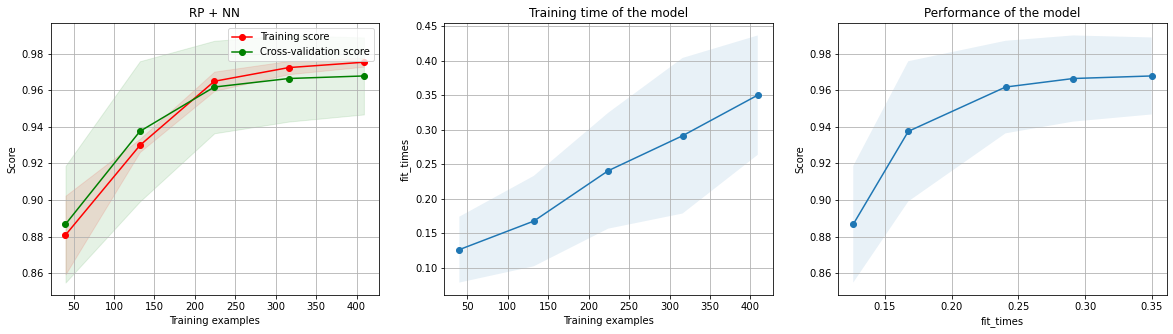

In [562]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=125,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="RP + NN", 
    X=x_train_transformed, 
    y=y_train,
    cv=10
)

In [563]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=125,
    random_state=0
)

final_nn_clf.fit(x_train_transformed, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_transformed)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.002710103988647461
Test Accuracy: 0.9385964912280702


## 4.4) LDA -> NN

In [564]:
# TODO

# 5) Clustering + NN

- 5.1) Kmeans + NN
- 5.2) EM + NN

## 5.1) Kmeans + NN

In [592]:
km = KMeans(2, random_state=0)
km = km.fit(x_train_sc)

train_labels = km.predict(x_train_sc)
test_labels = km.predict(x_test_sc)

In [594]:
x_train_kmeans = pd.DataFrame(x_train_sc)
x_test_kmeans = pd.DataFrame(x_test_sc)

In [595]:
x_train_kmeans['kmean_clusters'] = train_labels
x_test_kmeans['kmean_clusters'] = test_labels

#### check with A1 NN

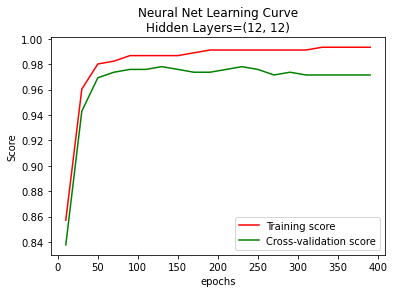

In [585]:
nn_per_epoch(
    X=x_train_kmeans, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

In [587]:
# nn_per_epoch(
#     X=x_train_kmeans, 
#     y=y_train, 
#     activation='relu',
#     alpha=0.01,
#     hidden_layer_size=(12, 12),
#     max_epoches=400
# )

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

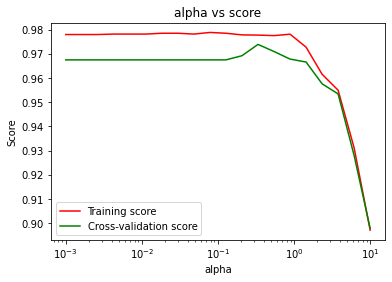

In [588]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=75,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_kmeans,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9781741260068036
Validation accuracy: 0.970607251521298
Train Time: 0.22803916931152343


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

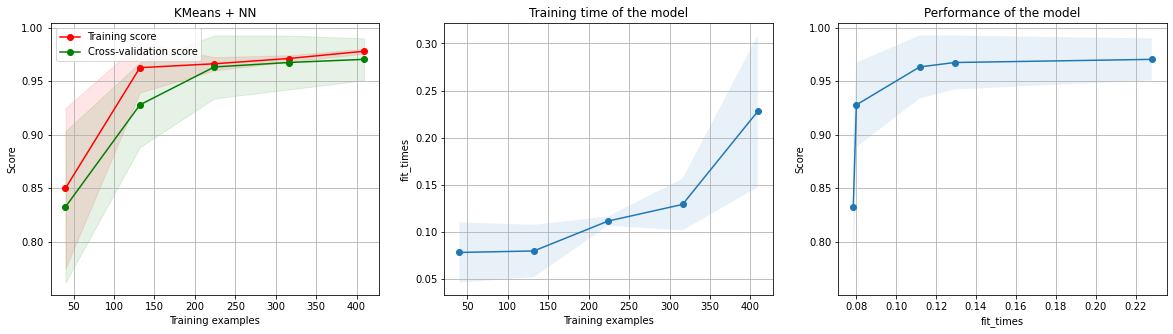

In [599]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=75,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="KMeans + NN", 
    X=x_train_kmeans, 
    y=y_train,
    cv=10
)

In [600]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=75,
    random_state=0
)

final_nn_clf.fit(x_train_kmeans, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_kmeans)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.003895998001098633
Test Accuracy: 0.956140350877193


## 5.2) EM + NN

In [615]:
gmm = GaussianMixture(2, random_state=1)
gmm = gmm.fit(x_train_sc)

train_labels = gmm.predict(x_train_sc)
test_labels = gmm.predict(x_test_sc)

In [616]:
x_train_em = pd.DataFrame(x_train_sc)
x_test_em = pd.DataFrame(x_test_sc)

In [617]:
x_train_em['em_clusters'] = train_labels
x_test_em['em_clusters'] = test_labels

#### Check with A1 NN

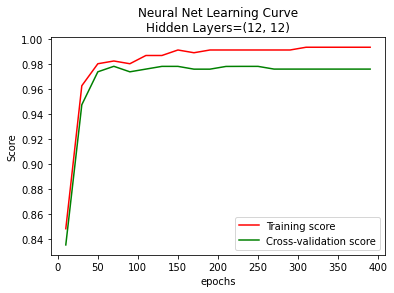

In [605]:
nn_per_epoch(
    X=x_train_em, 
    y=y_train, 
    activation='relu',
    alpha=0.1,
    hidden_layer_size=(12, 12),
    max_epoches=400
)

#### Tune alpha

<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

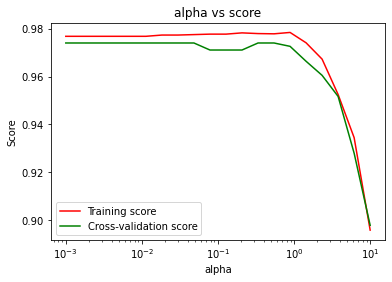

In [609]:
param_range = np.logspace(-3, 1, 20)

nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=75,
    random_state=0
)

plot_model_curve(
    estimator=nn_clf,
    title="alpha vs score",
    X=x_train_em,
    y=y_train,
    param_name="alpha",
    param_range=param_range,
    cv=10,
    x_scale_is_log=True
)

Train accuracy: 0.9782209035535813
Validation accuracy: 0.9735484279918865
Train Time: 0.2550757646560669


<module 'matplotlib.pyplot' from '/Users/rahal/opt/anaconda3/envs/cs7641/lib/python3.6/site-packages/matplotlib/pyplot.py'>

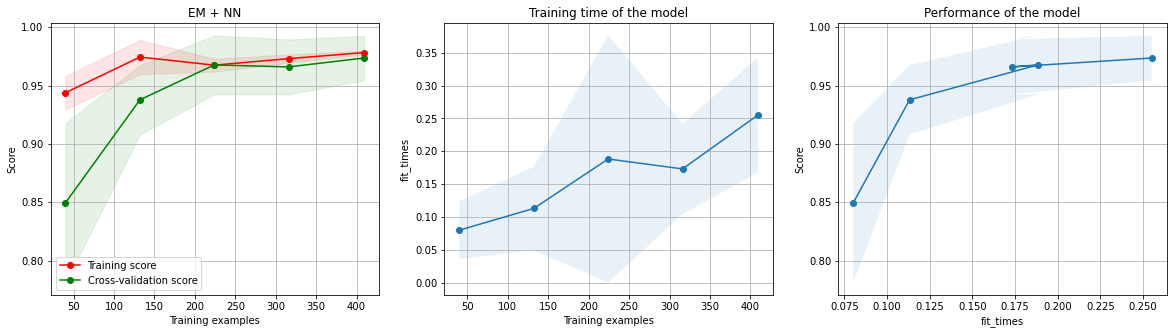

In [618]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=75,
    random_state=0
)

plot_learning_curve(
    estimator=final_nn_clf, 
    title="EM + NN", 
    X=x_train_em, 
    y=y_train,
    cv=10
)

In [619]:
final_nn_clf = MLPClassifier(
    hidden_layer_sizes=(12, 12),
    activation='relu', 
    alpha=0.1, 
    max_iter=75,
    random_state=0
)

final_nn_clf.fit(x_train_em, y_train)

st = time.time()
dt_y_preds = final_nn_clf.predict(x_test_em)
et = time.time()

print("Test Time: ", (et-st))
print("Test Accuracy:", accuracy_score(y_test, dt_y_preds))


Test Time:  0.0027141571044921875
Test Accuracy: 0.9473684210526315
